In [1]:
import numpy as np
import pandas as pd


import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression

from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
flights

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,...,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY
0,2015,1,1,4,AS,98,N407AS,ANC,SEA,5,...,408.0,-22.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
1,2015,1,1,4,AA,2336,N3KUAA,LAX,PBI,10,...,741.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
2,2015,1,1,4,US,840,N171US,SFO,CLT,20,...,811.0,5.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
3,2015,1,1,4,AA,258,N3HYAA,LAX,MIA,20,...,756.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,2015,1,1,4,AS,135,N527AS,SEA,ANC,25,...,259.0,-21.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,2015,1,1,4,DL,882,N651DL,SEA,DTW,1147,...,1827.0,-28.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4996,2015,1,1,4,UA,270,N843UA,DEN,BOI,1148,...,1334.0,-18.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4997,2015,1,1,4,UA,1439,N37252,IAH,SAN,1148,...,1308.0,-12.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4998,2015,1,1,4,OO,5555,N962SW,RAP,DEN,1148,...,1348.0,38.0,0,0,NaN,0.0,0.0,0.0,38.0,0.0


In [ ]:
flights.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 31 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   YEAR                 5000 non-null   int64  
 1   MONTH                5000 non-null   int64  
 2   DAY                  5000 non-null   int64  
 3   DAY_OF_WEEK          5000 non-null   int64  
 4   AIRLINE              5000 non-null   object 
 5   FLIGHT_NUMBER        5000 non-null   int64  
 6   TAIL_NUMBER          4994 non-null   object 
 7   ORIGIN_AIRPORT       5000 non-null   object 
 8   DESTINATION_AIRPORT  5000 non-null   object 
 9   SCHEDULED_DEPARTURE  5000 non-null   int64  
 10  DEPARTURE_TIME       4715 non-null   float64
 11  DEPARTURE_DELAY      4715 non-null   float64
 12  TAXI_OUT             4714 non-null   float64
 13  WHEELS_OFF           4714 non-null   float64
 14  SCHEDULED_TIME       5000 non-null   int64  
 15  ELAPSED_TIME         4703 non-null   f

In [ ]:

flights.isnull().values.any()

True

<AxesSubplot:xlabel='CANCELLATION_REASON', ylabel='count'>

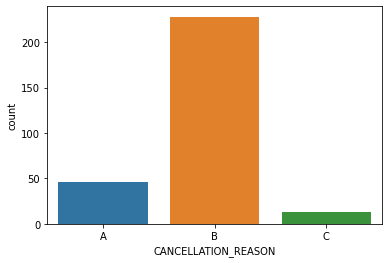

In [ ]:

sns.countplot(x='CANCELLATION_REASON',data=flights)

In [ ]:
def preprocess_inputs(df):
    df = df.copy()
    
    # Remove columns with more than 25% missing values
    missing_columns = df.loc[:, df.isna().mean() >= 0.25].columns
    df = df.drop(missing_columns, axis=1)
    
    # Drop unneeded columns
    df = df.drop(['YEAR', 'MONTH', 'FLIGHT_NUMBER', 'TAIL_NUMBER'], axis=1)
    
    # One-hot encode nominal feature columns
    df = onehot_encode(
        df,
        column_dict={
            'AIRLINE': 'AL',
            'ORIGIN_AIRPORT': 'OA',
            'DESTINATION_AIRPORT': 'DA'
        }
    )
    
    # Fill remaining missing values with column means
    remaining_na_columns = df.loc[:, df.isna().sum() > 0].columns
    for column in remaining_na_columns:
        df[column] = df[column].fillna(df[column].mean())
    
    # Split df into X and y
    y = df['CANCELLED'].copy()
    X = df.drop('CANCELLED', axis=1).copy()
    
    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=123)
    
    # Scale X with a standard scaler
    scaler = StandardScaler()
    scaler.fit(X_train)
    
    X_train = pd.DataFrame(scaler.transform(X_train), columns=X.columns)
    X_test = pd.DataFrame(scaler.transform(X_test), columns=X.columns)
   
    return X_train, X_test, y_train, y_test

In [ ]:
def evaluate_model(model, X_test, y_test):
    
    model_acc = model.score(X_test, y_test)
    print("Test Accuracy: {:.2f}%".format(model_acc * 100))
    
    y_true = np.array(y_test)
    y_pred = model.predict(X_test)
    
    cm = confusion_matrix(y_true, y_pred)
    clr = classification_report(y_true, y_pred, target_names=["NOT CANCELLED", "CANCELLED"])
    
    plt.figure(figsize=(8, 8))
    sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)
    plt.xticks(np.arange(2) + 0.5, ["NOT CANCELLED", "CANCELLED"])
    plt.yticks(np.arange(2) + 0.5, ["NOT CANCELLED", "CANCELLED"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()
    
    print("Classification Report:\n----------------------\n", clr)

In [ ]:
X_train, X_test, y_train, y_test = preprocess_inputs(flights)
X_train

,DAY,DAY_OF_WEEK,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,...,DA_TUS,DA_TVC,DA_TXK,DA_TYR,DA_TYS,DA_VEL,DA_VPS,DA_WRG,DA_XNA,DA_YUM
0,0.0,0.0,0.936213,0.874259,-0.195593,0.010132,1.043759,1.487084,1.472850,1.524071,...,-0.058655,-0.016906,0.0,-0.016906,-0.02929,0.0,-0.016906,-0.016906,-0.02929,-0.016906
1,0.0,0.0,0.309645,0.623113,0.952457,0.282701,0.590023,1.108118,0.833390,0.850047,...,-0.058655,-0.016906,0.0,-0.016906,-0.02929,0.0,-0.016906,-0.016906,-0.02929,-0.016906
2,0.0,0.0,0.962320,-0.003034,-0.009363,0.000447,-0.001520,-1.292000,0.000523,0.000765,...,-0.058655,-0.016906,0.0,-0.016906,-0.02929,0.0,-0.016906,-0.016906,-0.02929,-0.016906
3,0.0,0.0,1.327818,1.807088,2.285675,-0.671291,1.758262,-1.001459,-1.098039,-1.053080,...,-0.058655,-0.016906,0.0,-0.016906,-0.02929,0.0,-0.016906,-0.016906,-0.02929,-0.016906
4,0.0,0.0,0.153003,-0.114949,-0.306694,-1.216429,-0.009743,-0.660390,-0.745683,-0.577298,...,-0.058655,-0.016906,0.0,-0.016906,-0.02929,0.0,-0.016906,-0.016906,-0.02929,-0.016906
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3495,0.0,0.0,-0.369136,-0.637742,-0.380762,5.597799,-0.280941,3.129270,3.952387,3.453630,...,-0.058655,-0.016906,0.0,-0.016906,-0.02929,0.0,-0.016906,-0.016906,-0.02929,-0.016906
3496,0.0,0.0,0.936213,0.843507,-0.417796,-0.398722,0.788206,-0.028780,-0.067073,0.004213,...,-0.058655,-0.016906,0.0,-0.016906,-0.02929,0.0,-0.016906,-0.016906,-0.02929,-0.016906
3497,0.0,0.0,-0.708527,-0.750502,-0.269660,-0.398722,-0.833769,0.539669,0.102579,0.215671,...,-0.058655,-0.016906,0.0,-0.016906,-0.02929,0.0,-0.016906,-0.016906,-0.02929,-0.016906
3498,0.0,0.0,0.716914,0.643615,-0.306694,0.010132,0.600454,-0.445642,-0.523830,-0.511217,...,-0.058655,-0.016906,0.0,-0.016906,-0.02929,0.0,-0.016906,-0.016906,-0.02929,-0.016906


In [ ]:
y_train

4036    0
2883    0
4162    1
4640    0
2430    0
       ..
1593    0
4060    0
1346    0
3454    0
3582    0
Name: CANCELLED, Length: 3500, dtype: int64

In [ ]:
model = LogisticRegression()
model.fit(X_train, y_train)

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


LogisticRegression()

Test Accuracy: 96.20%


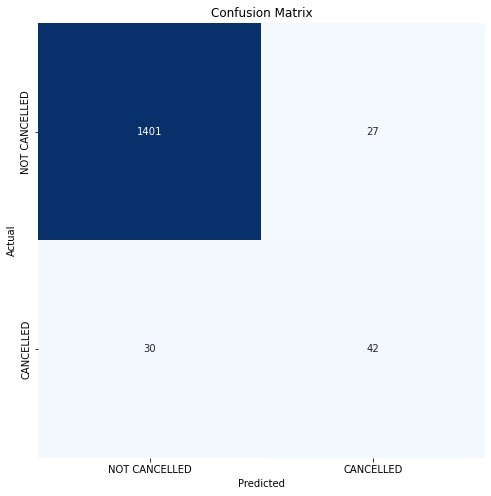

Classification Report:
----------------------
                precision    recall  f1-score   support

NOT CANCELLED       0.98      0.98      0.98      1428
    CANCELLED       0.61      0.58      0.60        72

     accuracy                           0.96      1500
    macro avg       0.79      0.78      0.79      1500
 weighted avg       0.96      0.96      0.96      1500



In [ ]:
evaluate_model(model, X_test, y_test)